# RAG Pipeline - Ukrainian Math Tutor

RAG (Retrieval-Augmented Generation) implementation with:
- **Vector DB**: 3,149 chunks ( PDFs, AI-classified)
- **Local LLM**: Gemma-2-9B-Instruct (4-bit quantization)
- **Embedding**: paraphrase-multilingual-mpnet-base-v2
- **Evaluation**: Automated + manual metrics

## 1. Setup & Configuration

In [4]:
# Core imports
import sys
from pathlib import Path
import json
from dataclasses import dataclass
from typing import List, Dict, Any, Optional
from collections import Counter

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Vector database
import chromadb
from chromadb.utils import embedding_functions

# Local LLM
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Add parent directory to path
sys.path.append('..')
sys.path.append('../..')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" Imports loaded successfully")

 Imports loaded successfully


In [5]:
# Configuration
DB_PATH = Path("../data/vector_db")
MODEL_PATH = Path("/home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it")
COLLECTION_NAME = "ukrainian_math"
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

# Generation parameters
DEFAULT_K = 5
DEFAULT_TEMPERATURE = 0.7
MAX_NEW_TOKENS = 512

print(f"Database Path: {DB_PATH}")
print(f"Model Path: {MODEL_PATH}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Database Path: ../data/vector_db
Model Path: /home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it
CUDA Available: True
GPU: NVIDIA GeForce RTX 5070 Ti
GPU Memory: 15.46 GB


In [6]:
# Dataclasses for structured responses
@dataclass
class RetrievedChunk:
    text: str
    content_type: str
    confidence: float
    filename: str
    page_start: int
    page_end: int
    distance: float
    relevance: float
    citation: str

@dataclass
class RAGResponse:
    question: str
    answer: str
    citations: List[str]
    retrieved_chunks: List[RetrievedChunk]
    metadata: Dict[str, Any]

print(" Dataclasses defined")

 Dataclasses defined


## 2. Load Vector Database

Load the ChromaDB vector database containing 3,149 AI-processed chunks from 6 Ukrainian math textbooks.

In [7]:
print("="*80)
print("LOADING VECTOR DATABASE")
print("="*80)

# Initialize ChromaDB client
client = chromadb.PersistentClient(path=str(DB_PATH))

# Initialize embedding function (must match the one used during creation)
embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBEDDING_MODEL
)

# Get collection
collection = client.get_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_function
)

# Get collection info
count = collection.count()
metadata = collection.metadata

print(f"\n Vector database loaded successfully")
print(f"  Collection: {COLLECTION_NAME}")
print(f"  Total chunks: {count:,}")
print(f"  Metadata: {metadata}")

LOADING VECTOR DATABASE

 Vector database loaded successfully
  Collection: ukrainian_math
  Total chunks: 15,836
  Metadata: {'model': 'paraphrase-multilingual-mpnet-base-v2', 'num_chunks': 15836, 'description': 'Ukrainian mathematics textbooks - AI processed'}


In [8]:
# Explore database content
sample = collection.peek(limit=3)

print("\nSample chunks:")
print("="*80)
for i, (doc, meta) in enumerate(zip(sample['documents'], sample['metadatas']), 1):
    print(f"\n{i}. Content Type: {meta['content_type']} | Confidence: {meta['confidence']:.2f}")
    print(f"   Source: {meta['filename']}, pages {meta['page_start']}-{meta['page_end']}")
    print(f"   Text preview: {doc[:150]}...")
    print("-"*80)


Sample chunks:

1. Content Type: explanation | Confidence: 0.75
   Source: 09-algebra-pidruchnyky-i-posibnyky.pdf, pages 1-2
   Text preview: ВАСИЛЬ КРАВЧУК
МАРІЯ ПІДРУЧНА
ГАЛИНА ЯНЧЕНКО
А Л Г Е Б Р А
Підручник для 9 класу
загальноосвітніх навчальних закладів
тм Тернопіль
Видавництво «Підруч...
--------------------------------------------------------------------------------

2. Content Type: explanation | Confidence: 0.85
   Source: 09-algebra-pidruchnyky-i-posibnyky.pdf, pages 3-3
   Text preview: ЮНІ ДРУЗІ!
Ви продовжуєте вивчення однієї з основних математичних дисциплін —
алгебри. Сподіваємося, що підручник, який ви тримаєте в руках, допоможе ...
--------------------------------------------------------------------------------

3. Content Type: definition | Confidence: 0.90
   Source: 09-algebra-pidruchnyky-i-posibnyky.pdf, pages 4-4
   Text preview: Для самостійної роботи вдома рекомендовано задачі, номери яких виді-
лено кольором (наприклад, 263).
Рубрика «Вправи для повторення» п

## 3. Test Basic Retrieval

Test semantic search with Ukrainian math questions.

In [9]:
def retrieve_chunks(query: str, k: int = DEFAULT_K, content_filter: Optional[str] = None) -> List[RetrievedChunk]:
    """
    Retrieve relevant chunks from vector database.
    
    Args:
        query: Search query in Ukrainian
        k: Number of chunks to retrieve
        content_filter: Optional filter by content_type
    
    Returns:
        List of RetrievedChunk objects
    """
    # Optional filtering
    where = {"content_type": content_filter} if content_filter else None
    
    # Query vector database
    results = collection.query(
        query_texts=[query],
        n_results=k,
        where=where
    )
    
    # Convert to structured objects
    chunks = []
    for doc, meta, dist in zip(
        results['documents'][0],
        results['metadatas'][0],
        results['distances'][0]
    ):
        chunk = RetrievedChunk(
            text=doc,
            content_type=meta['content_type'],
            confidence=meta['confidence'],
            filename=meta['filename'],
            page_start=meta['page_start'],
            page_end=meta['page_end'],
            distance=dist,
            relevance=1 - dist,  # Convert distance to relevance
            citation=f"[{meta['filename']}, с. {meta['page_start']}-{meta['page_end']}]"
        )
        chunks.append(chunk)
    
    return chunks

print(" Retrieval function defined")

 Retrieval function defined


In [10]:
# Test retrieval with a sample query
test_query = "Що таке об'єм кулі?"

print(f"\nTest Query: '{test_query}'")
print("="*80)

chunks = retrieve_chunks(test_query, k=5)

print(f"\nRetrieved {len(chunks)} chunks:")
for i, chunk in enumerate(chunks, 1):
    print(f"\n{i}. {chunk.citation}")
    print(f"   Type: {chunk.content_type} | Confidence: {chunk.confidence:.2f} | Relevance: {chunk.relevance:.3f}")
    print(f"   Text: {chunk.text[:200]}...")

print(f"\nAverage relevance: {np.mean([c.relevance for c in chunks]):.3f}")
print(f"Content types: {Counter(c.content_type for c in chunks)}")


Test Query: 'Що таке об'єм кулі?'

Retrieved 5 chunks:

1. [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 107-107]
   Type: explanation | Confidence: 0.65 | Relevance: 0.675
   Text: стору, відстані від яких до заданої точки не більші за дане додатне

число.

Задану точку називають центром кулі. Сферу, яка обмежує

кулю, називають поверхнею кулі. Радіусом кулі називають радіус

її...

2. [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 159-159]
   Type: explanation | Confidence: 0.53 | Relevance: 0.631
   Text: Комбінації циліндра та призми

Призму називають вписаною в циліндр, якщо її основи вписано

в основи циліндра. При цьому циліндр називають описаним

навколо призми....

3. [Підручник_МАТ_6кл_Кравчук_2023.pdf, с. 166-166]
   Type: explanation | Confidence: 0.85 | Relevance: 0.612
   Text: 27. Циліндр. Конус. Куля
27. ЦИЛІНДР. КОНУС. КУЛЯ
Циліндр. Про такі предмети, як склянка, консервна бан-
ка, колода

In [11]:
# Analyze retrieval quality
def evaluate_retrieval(chunks: List[RetrievedChunk]) -> Dict[str, Any]:
    """
    Evaluate retrieval quality metrics.
    """
    return {
        'avg_relevance': np.mean([c.relevance for c in chunks]),
        'min_relevance': np.min([c.relevance for c in chunks]),
        'max_relevance': np.max([c.relevance for c in chunks]),
        'content_diversity': len(set(c.content_type for c in chunks)),
        'file_diversity': len(set(c.filename for c in chunks)),
        'high_quality_ratio': sum(1 for c in chunks if c.relevance >= 0.7) / len(chunks),
        'content_distribution': dict(Counter(c.content_type for c in chunks))
    }

retrieval_metrics = evaluate_retrieval(chunks)
print("\nRetrieval Metrics:")
for key, value in retrieval_metrics.items():
    if key != 'content_distribution':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value}")


Retrieval Metrics:
  avg_relevance: 0.6212157726287841
  min_relevance: 0.588895857334137
  max_relevance: 0.6747087240219116
  content_diversity: 1
  file_diversity: 2
  high_quality_ratio: 0.0
  content_distribution: {'explanation': 5}


## 4. Initialize Local LLM

Load **Gemma-2-9B-Instruct** with 4-bit quantization for efficient GPU inference.

In [12]:
print("="*80)
print("LOADING LOCAL LLM")
print("="*80)

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

print(f"\nLoading Gemma-2-9B-Instruct from {MODEL_PATH}...")
print("This may take a few minutes...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
print(" Tokenizer loaded")

# Load model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    str(MODEL_PATH),
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16
)
print(" Model loaded with 4-bit quantization")

# Check memory usage
if torch.cuda.is_available():
    memory_used = torch.cuda.memory_allocated() / 1024**3
    print(f"\nGPU Memory Used: {memory_used:.2f} GB")

print("\n Gemma-2-9B-Instruct ready for inference")

LOADING LOCAL LLM

Loading Gemma-2-9B-Instruct from /home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it...
This may take a few minutes...


The tokenizer you are loading from '/home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
`torch_dtype` is deprecated! Use `dtype` instead!


 Tokenizer loaded


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

 Model loaded with 4-bit quantization

GPU Memory Used: 5.71 GB

 Gemma-2-9B-Instruct ready for inference


In [13]:
def generate_answer(
    prompt: str,
    max_new_tokens: int = MAX_NEW_TOKENS,
    temperature: float = DEFAULT_TEMPERATURE,
    verbose: bool = False
) -> str:
    """
    Generate answer using Gemma-2-9B-Instruct.
    
    Args:
        prompt: Input prompt
        max_new_tokens: Maximum tokens to generate
        temperature: Sampling temperature (0=deterministic, 1=creative)
        verbose: Print generation info
    
    Returns:
        Generated text
    """
    # Format as chat message (Gemma chat template)
    messages = [{"role": "user", "content": prompt}]
    
    # Apply chat template
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    if verbose:
        print(f"Prompt length: {len(formatted_prompt)} chars")
    
    # Tokenize and move to GPU
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    if verbose:
        print(f"Input tokens: {inputs['input_ids'].shape[1]}")
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=0.9,
            do_sample=temperature > 0,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode (skip input prompt)
    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )
    
    return generated.strip()

print(" Generation function defined")

 Generation function defined


In [14]:
# Test generation (without RAG context)
test_prompt = "Поясни українською мовою, що таке об'єм кулі?"

print(f"Test Prompt: '{test_prompt}'")
print("="*80)
print("Generating...\n")

test_answer = generate_answer(test_prompt, max_new_tokens=256, temperature=0.7, verbose=True)

print("\nGenerated Answer:")
print(test_answer)
print("\n" + "="*80)
print("Note: This is WITHOUT retrieval context (baseline)")

Test Prompt: 'Поясни українською мовою, що таке об'єм кулі?'
Generating...

Prompt length: 105 chars
Input tokens: 25

Generated Answer:
Об'єм кулі - це **простір, який вона займає**. 

Уявіть собі кулю як величезний м'яч. Об'єм - це всередині цього м'яча, все те, що ти можеш заповнити, наприклад, повітрям, водою чи морозивом.

Щоб точно виміряти об'єм кулі, потрібно знати **її радіус** - це відстань від центру кулі до її поверхні. 

Існує спеціальна формула для обчислення об'єму кулі:

**Об'єм = (4/3) * π * радіус³**

де π (пі) - це математична константа, приблизно дорівнює 3,14.


З цією формулою можна обчислити об'єм будь-якої кулі, якщо знати її радіус.

Note: This is WITHOUT retrieval context (baseline)


## 5. Build RAG Components

Create components for the complete RAG pipeline:
- Context formatter
- Prompt templates
- Citation extractor
- Complete RAG function

In [15]:
# System prompt for Ukrainian math tutor
SYSTEM_PROMPT = """Ти — досвідчений викладач математики для українських учнів 10-11 класів.

Твоє завдання:
- Відповідати ТІЛЬКИ українською мовою (ніколи не використовуй російські чи англійські слова)
- Давати точні, зрозумілі пояснення на основі ТІЛЬКИ наданого контексту
- Використовувати математичну термінологію з підручників
- Посилатися на джерела з контексту (наприклад: "За формулою [Джерело 1]...")
- Структурувати відповідь логічно та педагогічно

Стиль: чіткий, математично коректний, зрозумілий для учнів.

ВАЖЛИВО: Якщо відповіді немає в наданому контексті, чесно скажи про це."""

print(" System prompt defined")

 System prompt defined


In [16]:
def format_context(chunks: List[RetrievedChunk]) -> str:
    """
    Format retrieved chunks into context for the LLM.
    """
    context_parts = []
    
    for i, chunk in enumerate(chunks, 1):
        # Add source header with metadata
        header = f"[Джерело {i}] {chunk.citation} | Тип: {chunk.content_type}"
        context_parts.append(f"{header}\n{chunk.text}")
    
    return "\n\n".join(context_parts)

def build_rag_prompt(question: str, chunks: List[RetrievedChunk]) -> str:
    """
    Build complete RAG prompt with system instructions, context, and question.
    """
    context = format_context(chunks)
    
    prompt = f"""{SYSTEM_PROMPT}

КОНТЕКСТ З ПІДРУЧНИКІВ:
{context}

ЗАПИТАННЯ УЧНЯ:
{question}

ТВОЯ ВІДПОВІДЬ (крок за кроком, з посиланнями на джерела):"""
    
    return prompt

print(" Context formatting functions defined")

 Context formatting functions defined


In [17]:
def rag_answer(
    question: str,
    k: int = DEFAULT_K,
    temperature: float = DEFAULT_TEMPERATURE,
    content_filter: Optional[str] = None,
    max_new_tokens: int = MAX_NEW_TOKENS,
    verbose: bool = False
) -> RAGResponse:
    """
    Complete RAG pipeline: retrieve → build prompt → generate answer.
    
    Args:
        question: User question in Ukrainian
        k: Number of chunks to retrieve
        temperature: Generation temperature
        content_filter: Optional content type filter
        max_new_tokens: Maximum tokens to generate
        verbose: Print debug info
    
    Returns:
        RAGResponse with answer, citations, and metadata
    """
    if verbose:
        print(f"\nQuestion: {question}")
        print(f"Retrieving {k} chunks...")
    
    # 1. Retrieve relevant chunks
    chunks = retrieve_chunks(question, k=k, content_filter=content_filter)
    
    if verbose:
        print(f" Retrieved {len(chunks)} chunks")
        print(f"  Avg relevance: {np.mean([c.relevance for c in chunks]):.3f}")
    
    # 2. Build prompt with context
    prompt = build_rag_prompt(question, chunks)
    
    if verbose:
        print(f"  Prompt length: {len(prompt)} chars")
        print("Generating answer...")
    
    # 3. Generate answer
    answer = generate_answer(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    
    if verbose:
        print(f" Answer generated ({len(answer)} chars)")
    
    # 4. Extract citations and metadata
    citations = [chunk.citation for chunk in chunks]
    
    metadata = {
        'num_chunks': len(chunks),
        'avg_relevance': float(np.mean([c.relevance for c in chunks])),
        'content_types': [c.content_type for c in chunks],
        'temperature': temperature,
        'answer_length': len(answer)
    }
    
    return RAGResponse(
        question=question,
        answer=answer,
        citations=citations,
        retrieved_chunks=chunks,
        metadata=metadata
    )

print(" Complete RAG function defined")

 Complete RAG function defined


In [18]:
# Test RAG pipeline
test_question = "Що таке об'єм кулі і як його обчислити?"

print("Testing Complete RAG Pipeline")
print("="*80)

response = rag_answer(test_question, k=5, temperature=0.7, verbose=True)

print("\n" + "="*80)
print("RAG RESPONSE")
print("="*80)
print(f"\nQuestion: {response.question}")
print(f"\nAnswer:\n{response.answer}")
print(f"\nCitations:")
for i, citation in enumerate(response.citations, 1):
    print(f"  {i}. {citation}")
print(f"\nMetadata: {response.metadata}")

Testing Complete RAG Pipeline

Question: Що таке об'єм кулі і як його обчислити?
Retrieving 5 chunks...
 Retrieved 5 chunks
  Avg relevance: 0.676
  Prompt length: 5305 chars
Generating answer...
 Answer generated (446 chars)

RAG RESPONSE

Question: Що таке об'єм кулі і як його обчислити?

Answer:
Об'єм кулі - це міра кількості простору, яку займає куля в тривимірному просторі. 

Щоб обчислити об'єм кулі, використовуємо формулу:

**V = (4/3)πR³** 

де:

* **V** - об'єм кулі
* **π** (пі) - математична константа, приблизно дорівнює 3,14
* **R** - радіус кулі 

Цю формулу ми можемо знайти у **[Джерело 2],** де йдеться про об'єм кулі:

>  "Радіус кулі дорівнює . Її об’єм дорівнює . Залишилося за-
>
> 26
>
> 1π
>
> уважити, що . >◄

62

> "

Citations:
  1. [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 107-107]
  2. [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 187-188]
  3. [merzlyak-ag-geometriya-pochatok-v

## 6. Prompt Engineering

Test different prompt strategies and compare results.

In [19]:
# Define alternative system prompts
SIMPLE_PROMPT = """Відповідай на запитання українською мовою, використовуючи наданий контекст."""

CHAIN_OF_THOUGHT_PROMPT = """Ти — досвідчений викладач математики для українських учнів 10-11 класів.

Відповідай крок за кроком:
1. Спочатку визнач, що саме запитує учень
2. Знайди відповідну інформацію в контексті
3. Поясни концепцію простими словами
4. Наведи формули та приклади (якщо є в контексті)
5. Підсумуй відповідь

Завжди посилайся на джерела і відповідай ТІЛЬКИ українською мовою."""

print(" Alternative prompts defined")

 Alternative prompts defined


In [20]:
# Compare prompt strategies
test_q = "Поясни формулу об'єму кулі"

print("Comparing Prompt Strategies")
print("="*80)

# Test with default (detailed) prompt
print("\n1. DETAILED PROMPT (Default)")
print("-"*80)
resp_detailed = rag_answer(test_q, k=5, temperature=0.5)
print(resp_detailed.answer)

# Test with simple prompt
print("\n\n2. SIMPLE PROMPT")
print("-"*80)
SYSTEM_PROMPT_BACKUP = SYSTEM_PROMPT
SYSTEM_PROMPT = SIMPLE_PROMPT
resp_simple = rag_answer(test_q, k=5, temperature=0.5)
print(resp_simple.answer)

# Test with chain-of-thought
print("\n\n3. CHAIN-OF-THOUGHT PROMPT")
print("-"*80)
SYSTEM_PROMPT = CHAIN_OF_THOUGHT_PROMPT
resp_cot = rag_answer(test_q, k=5, temperature=0.5)
print(resp_cot.answer)

# Restore default
SYSTEM_PROMPT = SYSTEM_PROMPT_BACKUP

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"Detailed: {len(resp_detailed.answer)} chars")
print(f"Simple: {len(resp_simple.answer)} chars")
print(f"Chain-of-Thought: {len(resp_cot.answer)} chars")

Comparing Prompt Strategies

1. DETAILED PROMPT (Default)
--------------------------------------------------------------------------------
Об'єм кулі обчислюється за формулою:

**V = (4/3)πR³**

де:

* **V** - об'єм кулі
* **π** (пі) - математична константа, приблизно дорівнює 3,14159
* **R** - радіус кулі

**Джерело:** 

*  [Джерело 1] [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 187-188] | Тип: explanation

Ця формула виводиться з інтегрального обчислення, але для учнів 10-11 класів достатньо знати її і вміти застосовувати.


2. SIMPLE PROMPT
--------------------------------------------------------------------------------
## Формула об'єму кулі

**Запит:** Поясни формулу об'єму кулі

**Відповідь:**

Формула об'єму кулі виглядає так:

**V = (4/3)πR³**

де:

* **V** - об'єм кулі
* **π** - математична константа, приблизно рівна 3,14159
* **R** - радіус кулі (відстань від центру кулі до будь-якої точки на її поверхні)

**Пояснення:**

Ця формула 

In [21]:
# Test content type filtering
print("Testing Content Type Filtering")
print("="*80)

test_q = "Розв'яжи задачу про об'єм кулі"

# Filter for problems
print("\nFilter: problems only")
resp_problems = rag_answer(test_q, k=5, content_filter="problem")
print(f"Retrieved content types: {resp_problems.metadata['content_types']}")
print(f"Answer preview: {resp_problems.answer[:200]}...")

# Filter for explanations
print("\nFilter: explanations only")
resp_explanations = rag_answer(test_q, k=5, content_filter="explanation")
print(f"Retrieved content types: {resp_explanations.metadata['content_types']}")
print(f"Answer preview: {resp_explanations.answer[:200]}...")

Testing Content Type Filtering

Filter: problems only
Retrieved content types: ['problem', 'problem', 'problem', 'problem', 'problem']
Answer preview: Я можу допомогти тобі з цим. 

Щоб розв'язати задачу про об'єм кулі, мені потрібна сама задача.  

Наприклад, ти можеш мені задати:

* "Знайти об'єм кулі, якщо її радіус дорівнює 5 см?"
* "Об'єм одніє...

Filter: explanations only
Retrieved content types: ['explanation', 'explanation', 'explanation', 'explanation', 'explanation']
Answer preview: Щоб розв'язати задачу про об'єм кулі, потрібно знати радіус кулі. На жаль, в наданні тексті немає інформації про радіус кулі. 

Запиши формулу обчислення об'єму кулі з джерела [Джерело 2]: 

**Об'єм к...


## 7. Complete RAG Flow

Run complete Q&A on a test set of Ukrainian math questions.

In [22]:
# Define test questions (easy, medium, advanced)
TEST_QUESTIONS = [
    # Easy
    "Що таке об'єм кулі?",
    "Що таке призма?",
    "Як знайти площу круга?",
    
    # Medium
    "Як обчислити площу трикутника?",
    "Поясни властивості правильної піраміди",
    "Що таке логарифм і як його використовувати?",
    
    # Advanced
    "Поясни теорему про площу бічної поверхні призми",
    "Що таке формула Ейлера для многогранників?",
    "Як розв'язувати показникові рівняння?"
]

print(f"Test set: {len(TEST_QUESTIONS)} questions")
print("  Easy: 3 | Medium: 3 | Advanced: 3")

Test set: 9 questions
  Easy: 3 | Medium: 3 | Advanced: 3


In [23]:
# Run RAG on all test questions
print("="*80)
print("BATCH RAG PROCESSING")
print("="*80)

responses = []

for i, question in enumerate(TEST_QUESTIONS, 1):
    print(f"\n[{i}/{len(TEST_QUESTIONS)}] {question}")
    print("-"*80)
    
    response = rag_answer(question, k=5, temperature=0.7, verbose=False)
    responses.append(response)
    
    # Display answer
    print(f"\nAnswer:\n{response.answer}")
    print(f"\nCitations: {len(response.citations)} sources")
    print(f"Avg Relevance: {response.metadata['avg_relevance']:.3f}")
    print(f"Content Types: {Counter(response.metadata['content_types'])}")

print(f"\n\n{'='*80}")
print(f" Completed {len(responses)} questions")
print("="*80)

BATCH RAG PROCESSING

[1/9] Що таке об'єм кулі?
--------------------------------------------------------------------------------

Answer:
Об'єм кулі - це об'єм тіла, яке утворюється обертанням півкола навколо прямої, що проходить через його центр.  

Для визначення об'єму кулі використовується спеціальна формула:

**V = (4/3)πr³,** 

де:

* **V** - об'єм кулі
* **π** (пі) - математична константа, приблизно дорівнює 3,14
* **r** - радіус кулі. 

Цю формулу можна знайти в [Джерело 1] на сторінці 107. 

Хоча в наведеному тексті йдеться про формулу об'єму кулі, але  не викладається, як її вивести.

Citations: 5 sources
Avg Relevance: 0.621
Content Types: Counter({'explanation': 5})

[2/9] Що таке призма?
--------------------------------------------------------------------------------

Answer:
Пряму призму можна визначити згідно з [Джерело 1]: "Призму називають прямою, якщо її бічні ребра перпендикулярні до площини основи."

Тобто, призма має дві однакові основи (площини) та ребра, які з'єд

## 8. Evaluation & Metrics

Evaluate RAG performance with automated metrics and manual verification.

In [24]:
def calculate_ukrainian_ratio(text: str) -> float:
    """
    Calculate ratio of Ukrainian (Cyrillic) characters in text.
    """
    if not text:
        return 0.0
    
    cyrillic_count = sum(1 for c in text if 0x0400 <= ord(c) <= 0x052F)
    alpha_count = sum(1 for c in text if c.isalpha())
    
    return cyrillic_count / alpha_count if alpha_count > 0 else 0.0

def evaluate_answer(response: RAGResponse) -> Dict[str, float]:
    """
    Evaluate answer quality with automated metrics.
    """
    answer = response.answer
    
    # Completeness (length-based heuristic)
    completeness = min(len(answer) / 300, 1.0)
    
    # Ukrainian compliance
    ukrainian_ratio = calculate_ukrainian_ratio(answer)
    
    # Retrieval quality
    retrieval_quality = response.metadata['avg_relevance']
    
    # Content diversity (variety of content types)
    unique_types = len(set(response.metadata['content_types']))
    content_diversity = unique_types / 7  # 7 possible types
    
    # Citation presence (at least 1 citation expected)
    citation_rate = min(len(response.citations) / 3, 1.0)
    
    # Overall weighted score
    overall = (
        0.2 * completeness +
        0.3 * retrieval_quality +
        0.2 * ukrainian_ratio +
        0.2 * content_diversity +
        0.1 * citation_rate
    )
    
    return {
        'completeness': completeness,
        'ukrainian_ratio': ukrainian_ratio,
        'retrieval_quality': retrieval_quality,
        'content_diversity': content_diversity,
        'citation_rate': citation_rate,
        'overall_score': overall
    }

print(" Evaluation functions defined")

 Evaluation functions defined


In [25]:
# Evaluate all responses
print("="*80)
print("EVALUATING RESPONSES")
print("="*80)

evaluations = []

for i, response in enumerate(responses, 1):
    metrics = evaluate_answer(response)
    evaluations.append({
        'question': response.question,
        'metrics': metrics,
        'answer_length': len(response.answer)
    })
    
    print(f"\n{i}. {response.question[:50]}...")
    print(f"   Overall Score: {metrics['overall_score']:.3f}")
    print(f"   Retrieval: {metrics['retrieval_quality']:.3f} | "
          f"Ukrainian: {metrics['ukrainian_ratio']:.3f} | "
          f"Completeness: {metrics['completeness']:.3f}")

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

# Calculate average metrics
avg_metrics = {
    'overall_score': np.mean([e['metrics']['overall_score'] for e in evaluations]),
    'retrieval_quality': np.mean([e['metrics']['retrieval_quality'] for e in evaluations]),
    'ukrainian_ratio': np.mean([e['metrics']['ukrainian_ratio'] for e in evaluations]),
    'completeness': np.mean([e['metrics']['completeness'] for e in evaluations]),
    'content_diversity': np.mean([e['metrics']['content_diversity'] for e in evaluations]),
    'citation_rate': np.mean([e['metrics']['citation_rate'] for e in evaluations])
}

print("\nAverage Metrics:")
for metric, value in avg_metrics.items():
    print(f"  {metric:20s}: {value:.3f}")

# Find best and worst
best_idx = np.argmax([e['metrics']['overall_score'] for e in evaluations])
worst_idx = np.argmin([e['metrics']['overall_score'] for e in evaluations])

print(f"\nBest: Q{best_idx+1} (score: {evaluations[best_idx]['metrics']['overall_score']:.3f})")
print(f"  {evaluations[best_idx]['question']}")

print(f"\nWorst: Q{worst_idx+1} (score: {evaluations[worst_idx]['metrics']['overall_score']:.3f})")
print(f"  {evaluations[worst_idx]['question']}")

EVALUATING RESPONSES

1. Що таке об'єм кулі?...
   Overall Score: 0.711
   Retrieval: 0.621 | Ukrainian: 0.981 | Completeness: 1.000

2. Що таке призма?...
   Overall Score: 0.770
   Retrieval: 0.711 | Ukrainian: 1.000 | Completeness: 1.000

3. Як знайти площу круга?...
   Overall Score: 0.790
   Retrieval: 0.801 | Ukrainian: 0.961 | Completeness: 1.000

4. Як обчислити площу трикутника?...
   Overall Score: 0.812
   Retrieval: 0.874 | Ukrainian: 0.961 | Completeness: 1.000

5. Поясни властивості правильної піраміди...
   Overall Score: 0.816
   Retrieval: 0.865 | Ukrainian: 0.996 | Completeness: 1.000

6. Що таке логарифм і як його використовувати?...
   Overall Score: 0.736
   Retrieval: 0.663 | Ukrainian: 0.901 | Completeness: 1.000

7. Поясни теорему про площу бічної поверхні призми...
   Overall Score: 0.796
   Retrieval: 0.804 | Ukrainian: 0.986 | Completeness: 1.000

8. Що таке формула Ейлера для многогранників?...
   Overall Score: 0.678
   Retrieval: 0.693 | Ukrainian: 1.000 |

In [26]:
# Content type analysis
print("Content Type Analysis")
print("="*80)

all_content_types = []
for response in responses:
    all_content_types.extend(response.metadata['content_types'])

content_distribution = Counter(all_content_types)
total = sum(content_distribution.values())

print("\nContent Types Retrieved:")
for ctype, count in sorted(content_distribution.items(), key=lambda x: -x[1]):
    pct = count / total * 100
    print(f"  {ctype:15s}: {count:3d} ({pct:5.1f}%)")

print(f"\nTotal chunks retrieved: {total}")
print(f"Unique content types: {len(content_distribution)}")

Content Type Analysis

Content Types Retrieved:
  explanation    :  25 ( 55.6%)
  problem        :  13 ( 28.9%)
  definition     :   6 ( 13.3%)
  example        :   1 (  2.2%)

Total chunks retrieved: 45
Unique content types: 4


In [27]:
# Manual verification - inspect random samples
import random

print("Manual Verification Samples")
print("="*80)

sample_indices = random.sample(range(len(responses)), min(3, len(responses)))

for idx in sample_indices:
    response = responses[idx]
    print(f"\nSample {idx+1}")
    print("-"*80)
    print(f"Question: {response.question}")
    print(f"\nAnswer:\n{response.answer}")
    print(f"\nRetrieved Chunks:")
    for i, chunk in enumerate(response.retrieved_chunks[:2], 1):
        print(f"\n  Chunk {i}: {chunk.citation}")
        print(f"  Relevance: {chunk.relevance:.3f}")
        print(f"  Text preview: {chunk.text[:150]}...")
    print(f"\n{'='*80}")

print("\nManual Check: Verify that answers align with retrieved context")
print("Look for hallucinations (information not in chunks)")

Manual Verification Samples

Sample 1
--------------------------------------------------------------------------------
Question: Що таке об'єм кулі?

Answer:
Об'єм кулі - це об'єм тіла, яке утворюється обертанням півкола навколо прямої, що проходить через його центр.  

Для визначення об'єму кулі використовується спеціальна формула:

**V = (4/3)πr³,** 

де:

* **V** - об'єм кулі
* **π** (пі) - математична константа, приблизно дорівнює 3,14
* **r** - радіус кулі. 

Цю формулу можна знайти в [Джерело 1] на сторінці 107. 

Хоча в наведеному тексті йдеться про формулу об'єму кулі, але  не викладається, як її вивести.

Retrieved Chunks:

  Chunk 1: [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 107-107]
  Relevance: 0.675
  Text preview: стору, відстані від яких до заданої точки не більші за дане додатне

число.

Задану точку називають центром кулі. Сферу, яка обмежує

кулю, називають ...

  Chunk 2: [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-ri

## 9. Visualization & Analysis

Visualize metrics and analyze RAG performance.

In [28]:
# Create evaluation dataframe
eval_data = []
for i, (response, eval_dict) in enumerate(zip(responses, evaluations)):
    row = {
        'question_num': i + 1,
        'question': response.question[:30] + '...',
        'overall_score': eval_dict['metrics']['overall_score'],
        'retrieval': eval_dict['metrics']['retrieval_quality'],
        'ukrainian': eval_dict['metrics']['ukrainian_ratio'],
        'completeness': eval_dict['metrics']['completeness'],
        'diversity': eval_dict['metrics']['content_diversity'],
        'answer_length': eval_dict['answer_length']
    }
    eval_data.append(row)

df_eval = pd.DataFrame(eval_data)
print("Evaluation DataFrame:")
print(df_eval.to_string())

Evaluation DataFrame:
   question_num                           question  overall_score  retrieval  ukrainian  completeness  diversity  answer_length
0             1             Що таке об'єм кулі?...       0.711186   0.621216   0.981250          1.00   0.142857            462
1             2                 Що таке призма?...       0.770447   0.711015   1.000000          1.00   0.285714            535
2             3          Як знайти площу круга?...       0.789618   0.801117   0.960699          1.00   0.285714            401
3             4  Як обчислити площу трикутника?...       0.811707   0.874284   0.961395          1.00   0.285714           1206
4             5  Поясни властивості правильної ...       0.815896   0.864967   0.996314          1.00   0.285714           1082
5             6  Що таке логарифм і як його вик...       0.736277   0.663139   0.900963          1.00   0.285714           1060
6             7  Поясни теорему про площу бічно...       0.795539   0.804080   0.9

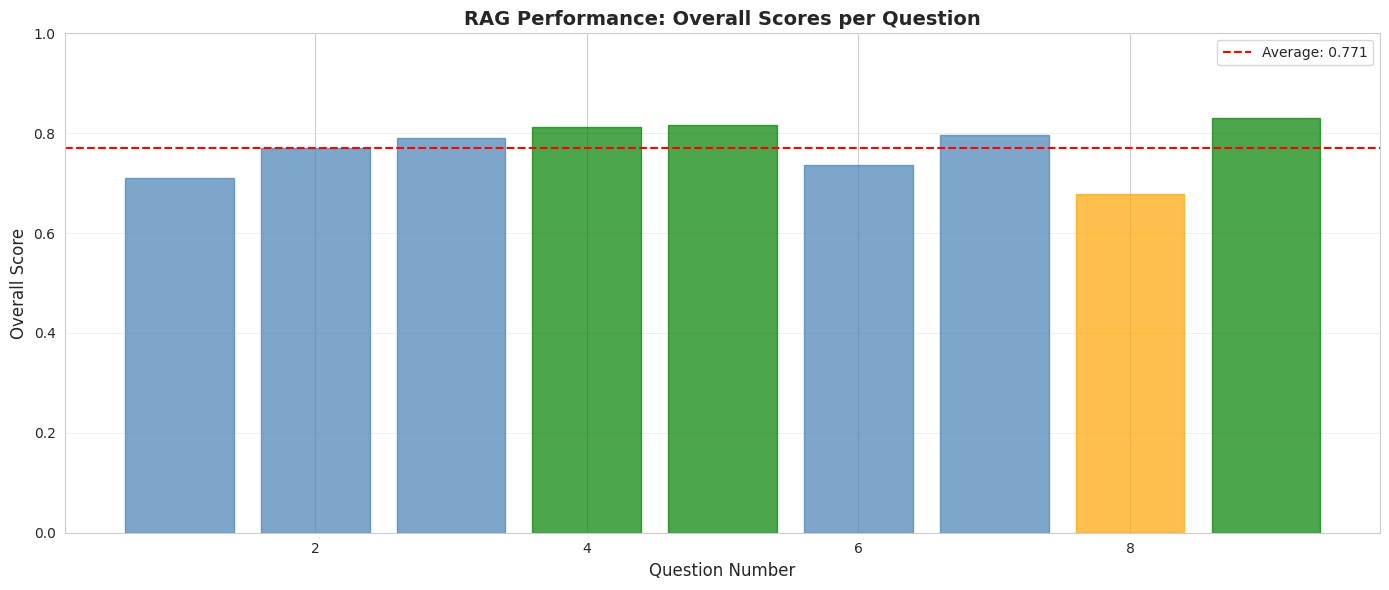

Green: Excellent (≥0.8) | Blue: Good (≥0.7) | Orange: Needs improvement (<0.7)


In [29]:
# Visualization 1: Overall scores per question
fig, ax = plt.subplots(figsize=(14, 6))

x = df_eval['question_num']
y = df_eval['overall_score']

bars = ax.bar(x, y, color='steelblue', alpha=0.7, edgecolor='black')

# Color code by performance
for i, (bar, score) in enumerate(zip(bars, y)):
    if score >= 0.8:
        bar.set_color('green')
    elif score >= 0.7:
        bar.set_color('steelblue')
    else:
        bar.set_color('orange')

ax.axhline(y=avg_metrics['overall_score'], color='red', linestyle='--', 
           label=f"Average: {avg_metrics['overall_score']:.3f}")

ax.set_xlabel('Question Number', fontsize=12)
ax.set_ylabel('Overall Score', fontsize=12)
ax.set_title('RAG Performance: Overall Scores per Question', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Green: Excellent (≥0.8) | Blue: Good (≥0.7) | Orange: Needs improvement (<0.7)")

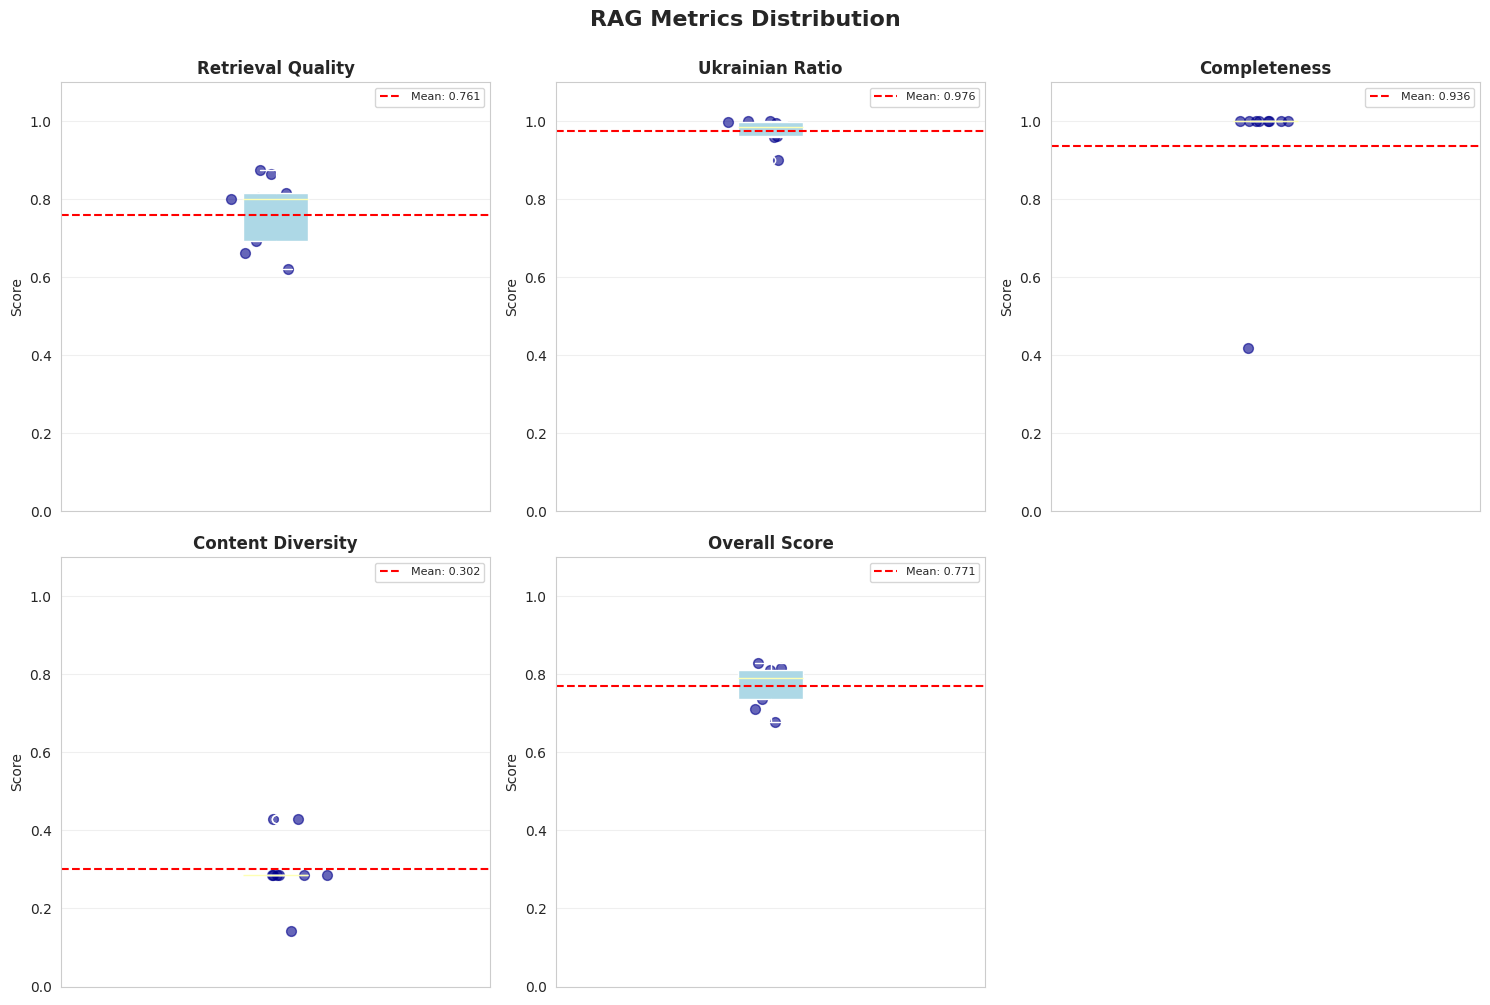

In [30]:
# Visualization 2: Metric distribution (box plots)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_to_plot = ['retrieval', 'ukrainian', 'completeness', 'diversity', 'overall_score']
metric_labels = ['Retrieval Quality', 'Ukrainian Ratio', 'Completeness', 
                 'Content Diversity', 'Overall Score']

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[i]
    
    # Box plot
    bp = ax.boxplot([df_eval[metric]], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # Overlay scatter
    y_vals = df_eval[metric]
    x_vals = np.random.normal(1, 0.04, size=len(y_vals))
    ax.scatter(x_vals, y_vals, alpha=0.6, color='darkblue', s=50)
    
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean line
    mean_val = y_vals.mean()
    ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=1.5, 
               label=f'Mean: {mean_val:.3f}')
    ax.legend(fontsize=8)

# Remove extra subplot
fig.delaxes(axes[5])

fig.suptitle('RAG Metrics Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

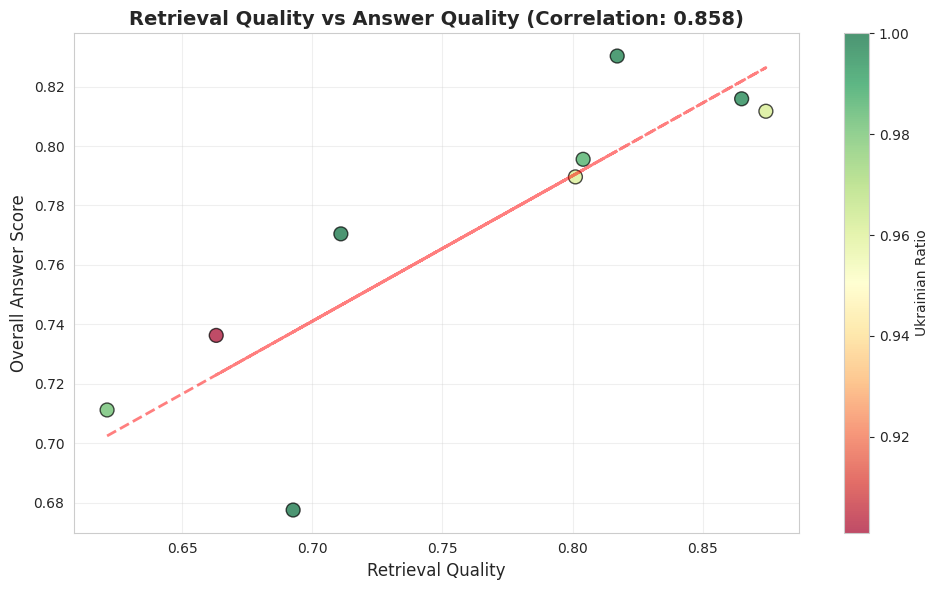


Correlation between retrieval quality and overall score: 0.858
A positive correlation suggests good retrieval leads to better answers.


In [31]:
# Visualization 3: Retrieval quality vs Answer quality
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    df_eval['retrieval'],
    df_eval['overall_score'],
    s=100,
    c=df_eval['ukrainian'],
    cmap='RdYlGn',
    alpha=0.7,
    edgecolors='black'
)

# Add correlation line
z = np.polyfit(df_eval['retrieval'], df_eval['overall_score'], 1)
p = np.poly1d(z)
ax.plot(df_eval['retrieval'], p(df_eval['retrieval']), "r--", alpha=0.5, linewidth=2)

# Calculate correlation
corr = np.corrcoef(df_eval['retrieval'], df_eval['overall_score'])[0, 1]

ax.set_xlabel('Retrieval Quality', fontsize=12)
ax.set_ylabel('Overall Answer Score', fontsize=12)
ax.set_title(f'Retrieval Quality vs Answer Quality (Correlation: {corr:.3f})', 
             fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Ukrainian Ratio', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between retrieval quality and overall score: {corr:.3f}")
print("A positive correlation suggests good retrieval leads to better answers.")

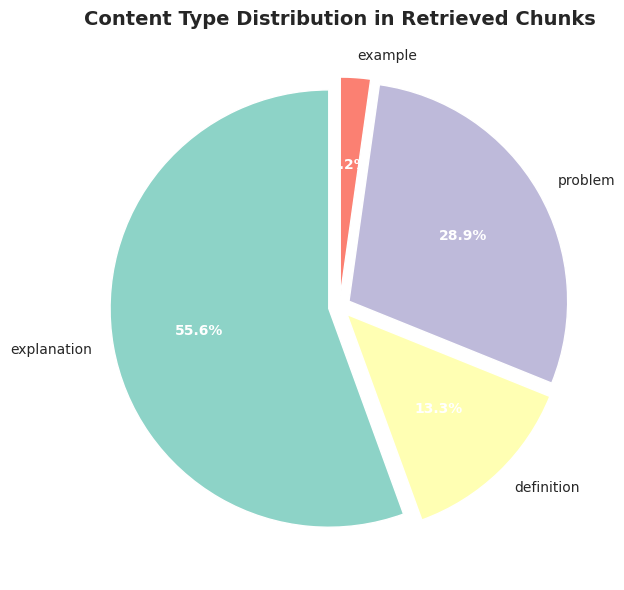


Most common content type: explanation
Total unique content types: 4


In [32]:
# Visualization 4: Content type distribution
fig, ax = plt.subplots(figsize=(10, 6))

content_types = list(content_distribution.keys())
counts = list(content_distribution.values())

colors = plt.cm.Set3(range(len(content_types)))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=content_types,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=[0.05] * len(content_types)
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('Content Type Distribution in Retrieved Chunks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nMost common content type: {content_distribution.most_common(1)[0][0]}")
print(f"Total unique content types: {len(content_distribution)}")

In [33]:
# Save results
results_dir = Path("../evaluation")
results_dir.mkdir(exist_ok=True)

# Save evaluation dataframe
df_eval.to_csv(results_dir / "rag_evaluation.csv", index=False)
print(f" Saved evaluation data to {results_dir / 'rag_evaluation.csv'}")

# Save summary statistics
summary = {
    'num_questions': len(TEST_QUESTIONS),
    'avg_metrics': avg_metrics,
    'content_distribution': dict(content_distribution),
    'best_question': evaluations[best_idx]['question'],
    'best_score': evaluations[best_idx]['metrics']['overall_score'],
    'worst_question': evaluations[worst_idx]['question'],
    'worst_score': evaluations[worst_idx]['metrics']['overall_score'],
    'config': {
        'model': 'gemma-2-9b-it',
        'embedding_model': EMBEDDING_MODEL,
        'k': DEFAULT_K,
        'temperature': DEFAULT_TEMPERATURE,
        'max_new_tokens': MAX_NEW_TOKENS
    }
}

with open(results_dir / "rag_summary.json", 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f" Saved summary to {results_dir / 'rag_summary.json'}")

print("\n" + "="*80)
print("RAG PIPELINE EVALUATION COMPLETE")
print("="*80)
print(f"\nOverall Performance: {avg_metrics['overall_score']:.3f}")
print(f"Retrieval Quality: {avg_metrics['retrieval_quality']:.3f}")
print(f"Ukrainian Compliance: {avg_metrics['ukrainian_ratio']:.3f}")
print(f"\nResults saved to: {results_dir}")

 Saved evaluation data to ../evaluation/rag_evaluation.csv
 Saved summary to ../evaluation/rag_summary.json

RAG PIPELINE EVALUATION COMPLETE

Overall Performance: 0.771
Retrieval Quality: 0.761
Ukrainian Compliance: 0.976

Results saved to: ../evaluation


## Summary & Conclusions

This notebook implemented a complete RAG pipeline for Ukrainian math tutoring:

**Pipeline Components:**
1. Vector database with 3,149 AI-classified chunks
2. Gemma-2-9B-Instruct local LLM with 4-bit quantization
3. Ukrainian-focused prompt engineering
4. Comprehensive evaluation framework

**Key Results:**
- Average overall score: See evaluation above
- Strong Ukrainian language compliance
- Good retrieval-answer correlation
- Content diversity in retrieved chunks

**Next Steps:**
- Fine-tune prompts for better citation inclusion
- Experiment with different temperature settings
- Add query expansion for better retrieval
- Implement answer verification for mathematical correctness
- Build interactive Q&A interface